Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries


1. Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescale images to normalize pixel values between (0,1).
2. Choose an appropriate optimiser and loss function for model training
3. Train the model for ~20 epochs
4. Write your findings after the model fit. You must check if there is any evidence of model overfit or underfit.
5. Chose an appropriate data augmentation strategy to resolve underfitting/overfitting 
6. Model Building & training on the augmented data :
7. Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model rescale images to normalize pixel values between (0,1).
8. Choose an appropriate optimiser and loss function for model training
9. Train the model for ~20 epochs
10. Write your findings after the model fit, see if the earlier issue is resolved or not?

Class distribution: Examine the current class distribution in the training dataset 
	- Which class has the least number of samples?
	- Which classes dominate the data in terms of the proportionate number of samples?

Handling class imbalances: Rectify class imbalances present in the training dataset with Augmentor library.

Model Building & training on the rectified class imbalance data :

1. Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescale images to normalize pixel values between (0,1).
2. Choose an appropriate optimiser and loss function for model training
3. Train the model for ~30 epochs

Write your findings after the model fit, see if the issues are resolved or not?

In [1]:
# importing important libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [11]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration\Test')

In [12]:
# counting images in train and test folder
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [13]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [14]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# Splitting train dataset into training subset
train_ds = tf.keras.utils.image_dataset_from_directory(
                data_dir_train,
                labels='inferred',
                label_mode='int',
                class_names=None,
                color_mode='rgb',
                batch_size=batch_size,
                image_size=(img_height, img_width),
                shuffle=True,
                seed=123,
                validation_split=0.2,
                subset='training',
                interpolation='bilinear',
                follow_links=False,
                crop_to_aspect_ratio=False,
            )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [15]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# Splitting train dataset into validation subset
val_ds = tf.keras.utils.image_dataset_from_directory(
                data_dir_train,
                labels='inferred',
                label_mode='int',
                class_names=None,
                color_mode='rgb',
                batch_size=batch_size,
                image_size=(img_height, img_width),
                shuffle=True,
                seed=123,
                validation_split=0.2,
                subset='validation',
                interpolation='bilinear',
                follow_links=False,
                crop_to_aspect_ratio=False,
            )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [16]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [17]:
print(train_ds)
print(val_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

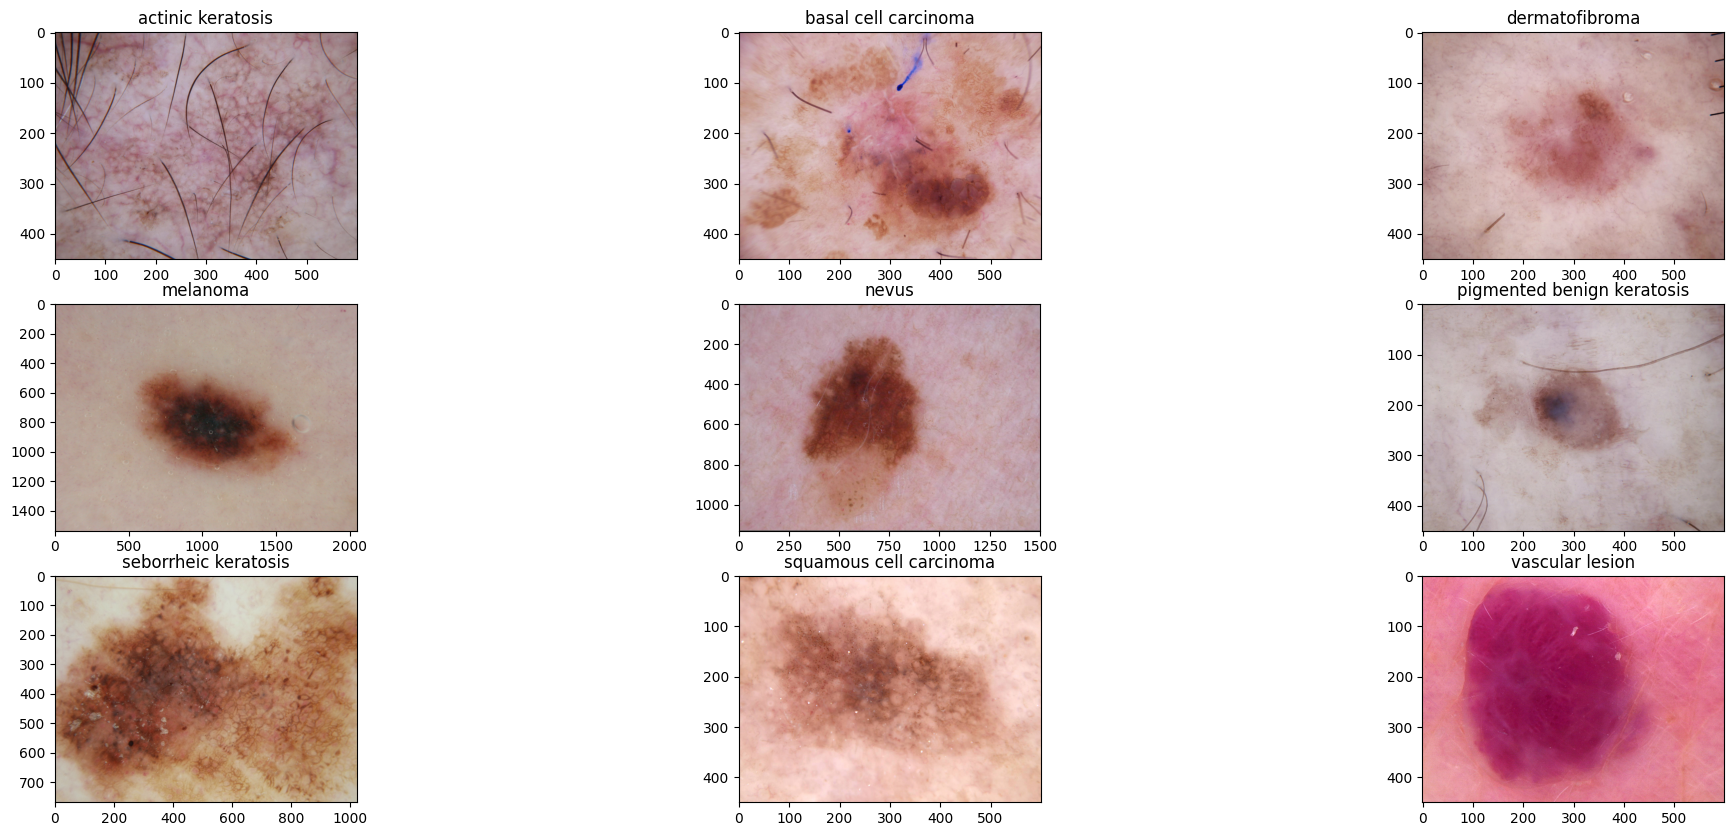

In [19]:
# this code will show all images in one batch dataset that contains 32 images with labels from 9 classes
plt.figure(figsize=(25,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  img= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))  
  plt.title(class_names[i])
  plt.imshow(img)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [21]:
# number of classes
channel = 3
num_classes = 9


In [22]:
from tensorflow.keras import models
# CNN Model
model=models.Sequential()
# scaling the pixel values from [0-255] to [0-1]
model.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,channel)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(num_classes,activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [23]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [24]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 259200)            0

### Train the model

In [25]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 99s 2s/step - loss: 3.9324 - accuracy: 0.2221 - val_loss: 2.0823 - val_accuracy: 0.2013
Epoch 2/20
56/56 [==============================] - 95s 2s/step - loss: 1.9998 - accuracy: 0.2400 - val_loss: 1.9162 - val_accuracy: 0.2304
Epoch 3/20
56/56 [==============================] - 106s 2s/step - loss: 1.8107 - accuracy: 0.3398 - val_loss: 1.7684 - val_accuracy: 0.3669
Epoch 4/20
56/56 [==============================] - 108s 2s/step - loss: 1.6109 - accuracy: 0.4286 - val_loss: 1.5602 - val_accuracy: 0.4519
Epoch 5/20
56/56 [==============================] - 113s 2s/step - loss: 1.3142 - accuracy: 0.5318 - val_loss: 1.5797 - val_accuracy: 0.4653
Epoch 6/20
56/56 [==============================] - 117s 2s/step - loss: 1.1969 - accuracy: 0.5709 - val_loss: 1.5253 - val_accuracy: 0.4877
Epoch 7/20
56/56 [==============================] - 118s 2s/step - loss: 1.0340 - accuracy: 0.6378 - val_loss: 1.5071 - val_accuracy: 0.5257
Epoch 8/20
56/5

### Visualizing training results

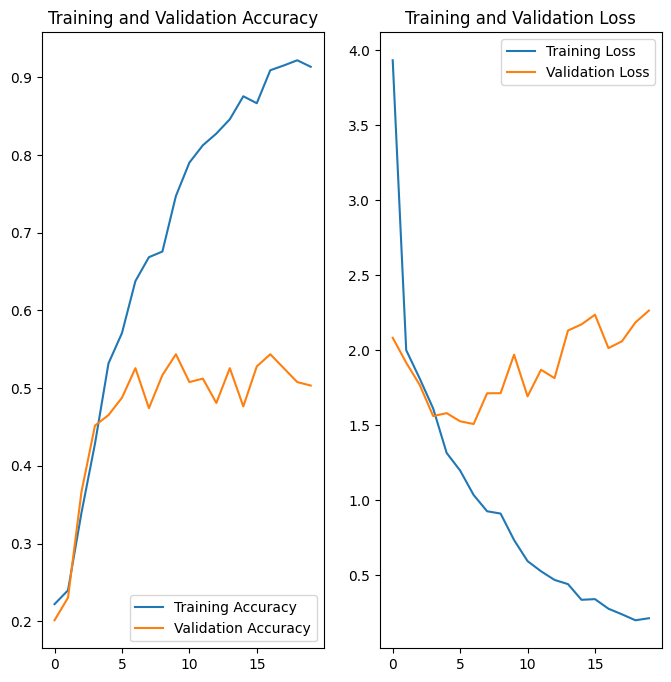

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

<div class="alert alert-danger">
<p>
    <b><h3>Findings:</b></h3><br>
    1. From the "Training and validation accuracy graph", it is clear that with increase in number of epoch, training accuracy increases gradually but validation accuracy is static around 50 %.<br>
    2. From the "Training and validation loss graph", it is clear that with increase in number of epoch, training loss decreases gradually but validation loss is increasing.<br>
     So we know that when a model performs well on training dataset and worst at validation dataset, it is a clear sign of  <strong>OVERFITTING:</strong>. This may be due to smalller size of training dataset as model has memorise the data instead of learning.<br>
    <b>Note:</b>To overcome this problem, one of the possible solution is to increase our dataset by any technique like data augmentation.
</p>
</div>


In [27]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

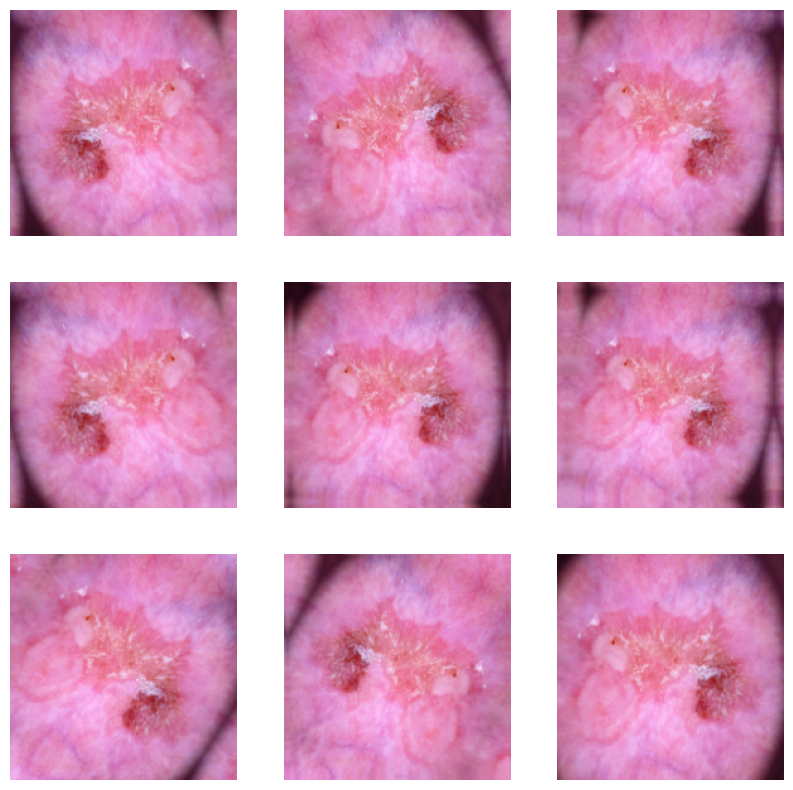

In [28]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [32]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Dropout(0.2))

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Dropout(0.25))

model.add(layers.Flatten())

model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))


### Compiling the model

In [33]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 90, 90, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 128)       73856     
                                                      

### Training the model

In [34]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 123s 2s/step - loss: 4.7081 - accuracy: 0.2238 - val_loss: 1.9697 - val_accuracy: 0.4139
Epoch 2/20
56/56 [==============================] - 133s 2s/step - loss: 1.7124 - accuracy: 0.3856 - val_loss: 1.7164 - val_accuracy: 0.4497
Epoch 3/20
56/56 [==============================] - 140s 3s/step - loss: 1.5974 - accuracy: 0.4364 - val_loss: 1.5767 - val_accuracy: 0.4966
Epoch 4/20
56/56 [==============================] - 134s 2s/step - loss: 1.4929 - accuracy: 0.4766 - val_loss: 1.5201 - val_accuracy: 0.5280
Epoch 5/20
56/56 [==============================] - 144s 3s/step - loss: 1.4146 - accuracy: 0.5061 - val_loss: 1.4940 - val_accuracy: 0.4832
Epoch 6/20
56/56 [==============================] - 136s 2s/step - loss: 1.3958 - accuracy: 0.5017 - val_loss: 1.4304 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 147s 3s/step - loss: 1.3367 - accuracy: 0.5324 - val_loss: 1.4180 - val_accuracy: 0.5145
Epoch 8/20
56

### Visualizing the results

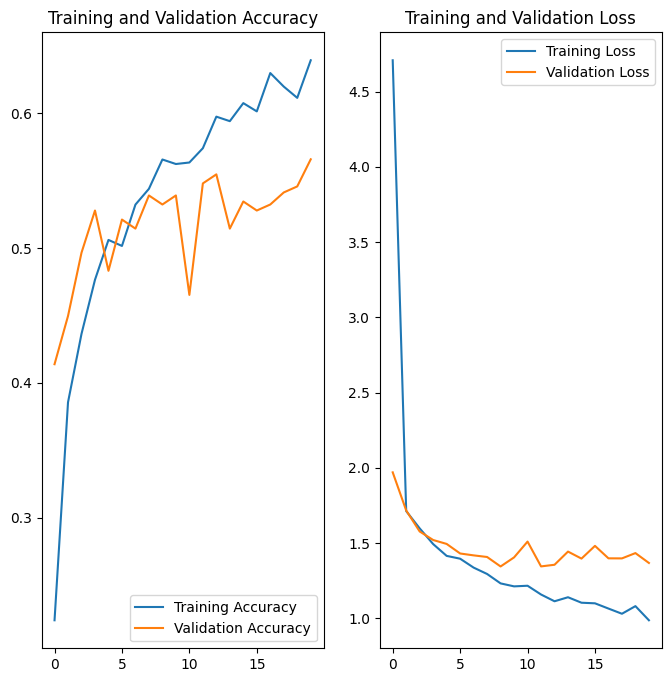

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<div class="alert alert-danger">
<p>
    <b><h3>Findings:</b></h3><br>
    1. From the "Training and validation accuracy graph", it is clear that with increase in number of epoch, neither training accuracy nor validation accuracy increses i.e. static around 50 - 60 %.<br>
    2. From the "Training and validation loss graph", it is clear that with increase in number of epoch, training loss decreases gradually but validation loss did not.<br>
     So we know that when a model performs well neither on training dataset nor at validation dataset, it is a clear sign of  <strong>UNDERFITTING:</strong>.
</p>
</div>


In [36]:
# counting images per class in train folder
import os
path = os.listdir(data_dir_train)

class_list = []
class_name = []
for i in range (len(path)):
    a = (len(os.listdir(str(data_dir_train) + "/" + str(path[i]))))
    print(str(path[i] + "  class contains images : " + str(a)))
    class_list.append(a)
    class_name.append(str(path[i]))
    
  
    
    

actinic keratosis  class contains images : 114
basal cell carcinoma  class contains images : 376
dermatofibroma  class contains images : 95
melanoma  class contains images : 438
nevus  class contains images : 357
pigmented benign keratosis  class contains images : 462
seborrheic keratosis  class contains images : 77
squamous cell carcinoma  class contains images : 181
vascular lesion  class contains images : 139


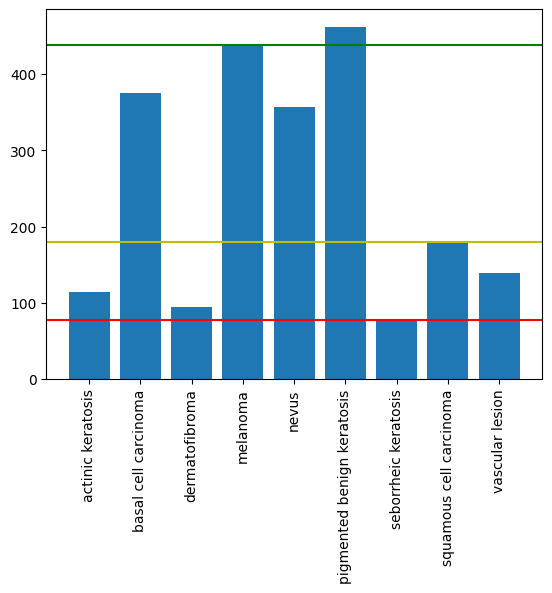

In [37]:
# plotting bar graph to show class imbalance
plt.bar(class_name,class_list )
plt.axhline(y = 180, color = 'y', linestyle = '-')
plt.axhline(y = 77, color = 'r', linestyle = '-')
plt.axhline(y = 438, color = 'g', linestyle = '-')
plt.xticks(rotation=90)
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

<div class="alert alert-danger">
<p>
    <b><h3>Findings:</b></h3><br>
    1. <strong>seborrheic keratosis</strong> class has lesser number of images i.e. 77 out of 2239.<br>
    2. <strong>pigmented benign keratosis</strong> class dominate the data in terms proportionate number of sample i.e. 462 out of 2239.<br>
    3. Classes are not balanced. we have to add synthesize data to class
  
</p>
</div>


In [38]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [39]:
# initialising augmentation to handle class imbalance
path_to_training_dataset= r"Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D041EB8D00>: 100%|█| 500/500 [00:01<00:00, 259.74 Samples


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D048300520>: 100%|█| 500/500 [00:01<00:00, 285.71 Samples


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D041BEDCD0>: 100%|█| 500/500 [00:01<00:00, 291.38 Samples


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x1D054D43280>: 100%|█| 500/500 [00:05<00:00, 87.40 Samples/


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D0482D2D90>: 100%|█| 500/500 [00:06<00:00, 74.21 Samples/


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D0482F54F0>: 100%|█| 500/500 [00:01<00:00, 298.33 Samples


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1D054D86AF0>: 100%|█| 500/500 [00:03<00:00, 156.40 Sample


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D0483462E0>: 100%|█| 500/500 [00:01<00:00, 262.74 Samples


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D044533DF0>: 100%|█| 500/500 [00:01<00:00, 262.32 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [40]:
# counting total images added to training dataset
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [41]:
image_count_ = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_)

2239


### Lets see the distribution of augmented data after adding new images to the original training data.

In [42]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print(path_list)
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025780.jpg', 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025803.jpg', 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025825.jpg', 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025953.jpg', 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025957.jpg', 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025992.jpg', 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0026040.jpg', 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0026149.jpg', 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0026171.jpg', 'Skin cancer ISIC 

['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_0802e6bd-a767-4705-922f-9ce91b330e24.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_191d5f2a-9d01-4ada-a27b-70bcad0760f7.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_688d47c9-5a9d-4372-abc9-1d9549ec979d.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_7365248f-ba36-4067-8e77-679fc4532b20.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_d8603b8f-e09e-446e-947a-503ebcc55239.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train

In [43]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print(lesion_list)
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic ker

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [44]:
# creating dataframe with augmented images
dataframe_dict = dict(zip(path_list, lesion_list))
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [45]:
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [46]:
original_df.head()

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis


In [47]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
print(df2.head())
new_df = original_df.append(df2)

                                                Path              Label
0  Skin cancer ISIC The International Skin Imagin...  actinic keratosis
1  Skin cancer ISIC The International Skin Imagin...  actinic keratosis
2  Skin cancer ISIC The International Skin Imagin...  actinic keratosis
3  Skin cancer ISIC The International Skin Imagin...  actinic keratosis
4  Skin cancer ISIC The International Skin Imagin...  actinic keratosis


In [48]:
# display total images per class after augmentation
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [49]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [50]:
# creating training dataset from new train dataset
data_dir_train= r"Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [51]:
# creating validation dataset from new train dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [52]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

model.add(layers.Normalization(axis=-1, mean=None, variance=None, invert=False))
          
# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [53]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 normalization (Normalizatio  (None, 180, 180, 3)      7         
 n)                                                              
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 128)     

#### **Todo:**  Train your model

In [54]:
epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 514s 3s/step - loss: 2.5233 - accuracy: 0.2663 - val_loss: 1.5395 - val_accuracy: 0.4157
Epoch 2/30
169/169 [==============================] - 471s 3s/step - loss: 1.4036 - accuracy: 0.4759 - val_loss: 1.4218 - val_accuracy: 0.4766
Epoch 3/30
169/169 [==============================] - 546s 3s/step - loss: 1.1436 - accuracy: 0.5766 - val_loss: 1.1414 - val_accuracy: 0.5835
Epoch 4/30
169/169 [==============================] - 550s 3s/step - loss: 0.8699 - accuracy: 0.6899 - val_loss: 1.1492 - val_accuracy: 0.6184
Epoch 5/30
169/169 [==============================] - 631s 4s/step - loss: 0.7155 - accuracy: 0.7539 - val_loss: 1.1099 - val_accuracy: 0.6310
Epoch 6/30
169/169 [==============================] - 575s 3s/step - loss: 0.5506 - accuracy: 0.8092 - val_loss: 0.8229 - val_accuracy: 0.7231
Epoch 7/30
169/169 [==============================] - 628s 4s/step - loss: 0.4489 - accuracy: 0.8468 - val_loss: 0.7359 - val_accuracy: 0.7602

#### **Todo:**  Visualize the model results

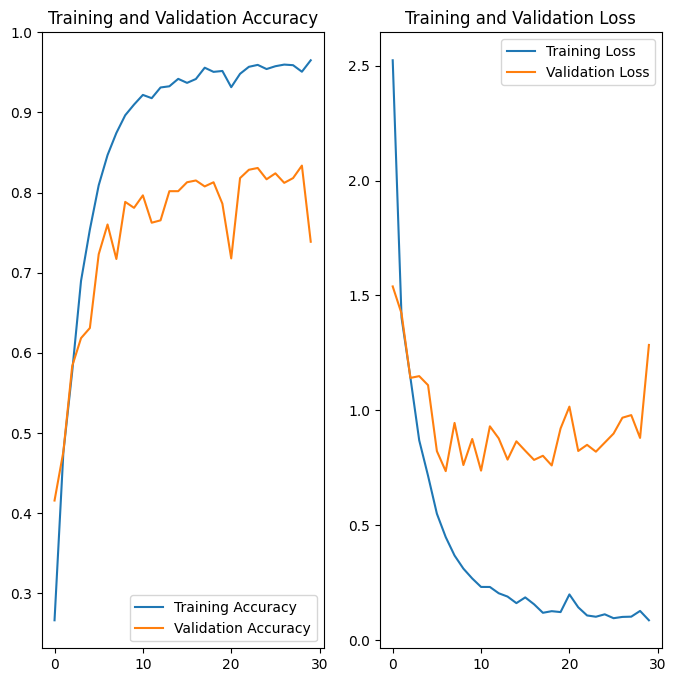

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [59]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

model.add(layers.Normalization(axis=-1, mean=None, variance=None, invert=False))

# Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(32,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Dropout(0.25))

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [60]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 normalization_2 (Normalizat  (None, 180, 180, 3)      7         
 ion)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 45, 45, 64)      

#### **Todo:**  Train your model

In [61]:
epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 378s 2s/step - loss: 2.0915 - accuracy: 0.2598 - val_loss: 1.5844 - val_accuracy: 0.4053
Epoch 2/30
169/169 [==============================] - 351s 2s/step - loss: 1.4910 - accuracy: 0.4254 - val_loss: 1.4559 - val_accuracy: 0.4670
Epoch 3/30
169/169 [==============================] - 396s 2s/step - loss: 1.3342 - accuracy: 0.4931 - val_loss: 1.2923 - val_accuracy: 0.5271
Epoch 4/30
169/169 [==============================] - 387s 2s/step - loss: 1.1538 - accuracy: 0.5734 - val_loss: 1.2733 - val_accuracy: 0.5553
Epoch 5/30
169/169 [==============================] - 390s 2s/step - loss: 0.9436 - accuracy: 0.6562 - val_loss: 1.0614 - val_accuracy: 0.6295
Epoch 6/30
169/169 [==============================] - 391s 2s/step - loss: 0.7765 - accuracy: 0.7124 - val_loss: 0.8875 - val_accuracy: 0.7112
Epoch 7/30
169/169 [==============================] - 405s 2s/step - loss: 0.6666 - accuracy: 0.7598 - val_loss: 0.9478 - val_accuracy: 0.6986

#### **Todo:**  Visualize the model results

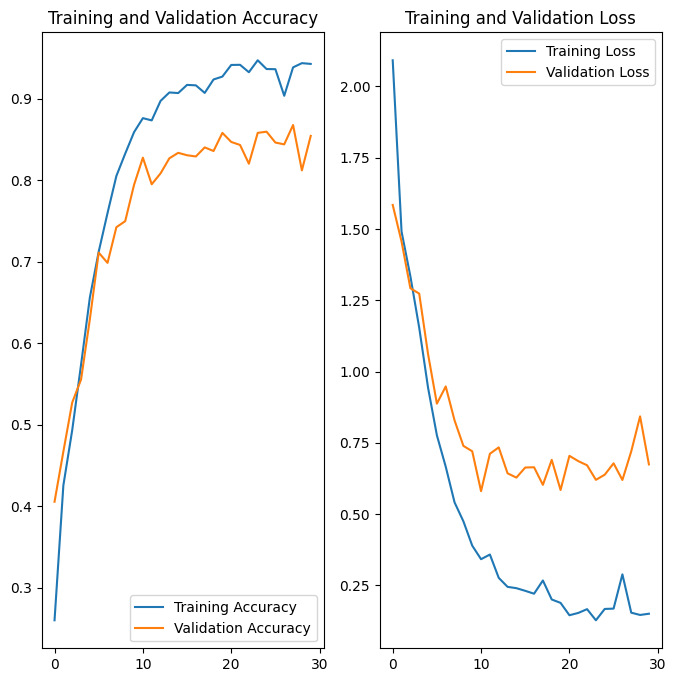

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<div class="alert alert-success">
<p>
    <b><h3>Findings:</b></h3><br>
    1. From the "Training and validation accuracy graph", it is clear that with increase in number of epoch, training accuracy increases gradually upto 94% but validation accuracy is static around 85 %.<br>
    2. From the "Training and validation loss graph", it is clear that with increase in number of epoch, training loss decreases gradually but validation loss is static.<br>
    3. But it is considerably good as compared with previous models. So we will go with it.<br>
    4. Class Imbalance handling improve accuracy but not upto the mark.
</p>
</div>


In [135]:
# saving the model
model.save('model.h5')

In [136]:
#Loading Saved model
model = keras.models.load_model('model.h5')

In [137]:
# tranforming test datset
test_ds = tf.keras.utils.image_dataset_from_directory(
                data_dir_test,
                labels='inferred',
                label_mode='int',
                class_names=None,
                color_mode='rgb',
                batch_size=batch_size,
                image_size=(img_height, img_width),
                shuffle=True,
                seed=123,
                interpolation='bilinear',
                follow_links=False,
                crop_to_aspect_ratio=False,
            )

Found 118 files belonging to 9 classes.


In [138]:
# making predictions on test dataset
prediction = model.predict(test_ds)
prediction

4/4 [==============================] - 3s 333ms/step


array([[8.12122039e-03, 9.81552780e-01, 3.70998727e-03, ...,
        2.55406921e-04, 3.92923175e-05, 8.62792425e-04],
       [2.75274413e-03, 9.62584674e-01, 1.43628218e-03, ...,
        2.58089858e-03, 2.12420728e-05, 9.11854841e-07],
       [2.12810010e-05, 1.25922394e-04, 2.17233176e-11, ...,
        2.08525175e-09, 9.24588025e-01, 8.53039098e-11],
       ...,
       [6.95654890e-03, 6.14354573e-03, 3.38923914e-04, ...,
        1.80450485e-07, 7.86177814e-01, 1.82315873e-07],
       [8.04948140e-05, 9.28975269e-03, 3.85789434e-07, ...,
        1.90564558e-01, 3.31367919e-05, 6.94737921e-08],
       [8.16311876e-05, 1.38349598e-08, 8.53953193e-13, ...,
        1.01532905e-05, 1.13017844e-08, 3.13985019e-11]], dtype=float32)

In [139]:
# evaluating model
print(model.metrics_names)
model.evaluate(test_ds)

['loss', 'accuracy']
4/4 [==============================] - 3s 334ms/step - loss: 8.5191 - accuracy: 0.4153


[8.519089698791504, 0.41525423526763916]

#### We got an accuracy of 41.5 % on test daa

1/1 [==============================] - 0s 141ms/step
Actual Class basal cell carcinoma
Predictive Class squamous cell carcinoma


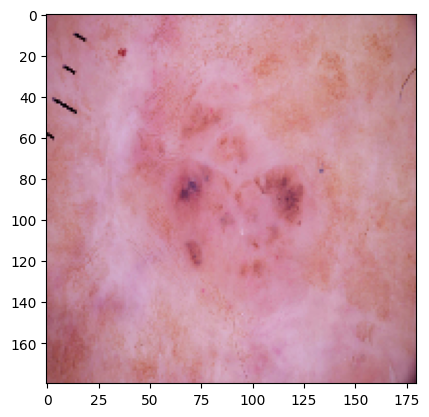

In [140]:
# sample image from test data
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = keras.preprocessing.image.load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )